<a href="https://colab.research.google.com/github/24ta/2021dataSeminar/blob/master/06/06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第06回データ分析勉強会（2020/01/17）
## データの見直しと予測 ~ kickstart project 3回目~
### 使用データ：[Kickstarter Projects](https://www.kaggle.com/kemical/kickstarter-projects) <br>
参考URL：<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　～コード説明１～"](https://ds-blog.tbtech.co.jp/entry/2019/04/19/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E8%AA%AC%E6%98%8E%EF%BC%91%EF%BD%9E)<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　～コード説明２～"](https://ds-blog.tbtech.co.jp/entry/2019/04/27/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E8%AA%AC%E6%98%8E%EF%BC%92%EF%BD%9E)<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　〜コード修正〜"](https://ds-blog.tbtech.co.jp/entry/2019/05/13/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E3%82%B3%E3%83%BC%E3%83%89%E4%BF%AE%E6%AD%A3%EF%BD%9E)<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　〜隠されしデータの全貌①〜"](https://ds-blog.tbtech.co.jp/entry/2019/06/05/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E9%9A%A0%E3%81%95%E3%82%8C%E3%81%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%85%A8%E8%B2%8C%E2%91%A0%EF%BD%9E)<br>
[テービーテックのデータサイエンス "Kaggleに挑戦しよう！　〜隠されしデータの全貌②〜"](https://ds-blog.tbtech.co.jp/entry/2019/06/12/Kaggle%E3%81%AB%E6%8C%91%E6%88%A6%E3%81%97%E3%82%88%E3%81%86%EF%BC%81_%EF%BD%9E%E9%9A%A0%E3%81%95%E3%82%8C%E3%81%97%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E5%85%A8%E8%B2%8C%E2%91%A1%EF%BD%9E)

# import libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline  #matplotlibのグラフを表示する
import seaborn as sns #matplotlibより美しいグラフの描画
from sklearn.preprocessing import StandardScaler #preprocessing：前処理  StandardScaler：標準化
from sklearn.model_selection import train_test_split #データを訓練データとテストデータに分割する
from sklearn.linear_model import SGDClassifier #クラス分類をする
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix 
#log_loss：対数尤度 ,accuracy_score：正答率 ,precision_recall_fscore_support：適合率,再現率,F1値 ,confusion_matrix：クロス集計表
from sklearn.metrics import mean_absolute_error #平均絶対誤差
import datetime as dt #日時を扱う
import urllib.request
from urllib.request import urlopen
from io import StringIO

# read data

In [63]:
import codecs
with codecs.open('./ks-projects-201612.csv', 'r', 'utf-8', 'ignore') as file:
    df = pd.read_csv(file, delimiter=",")
df.columns = df.columns.str.replace(" ", "")
df = df.loc[:, ~df.columns.str.match('Unnamed')]

# 前処理

In [64]:
# 今回のデータでは、そのまま使用することが難しそうな変数がある。例えば、"deadline"と"launched"。具体的な日付自体を確認して得られるものは無く、それより当該プロジェクトが発足してから締切までの経過日数の方が重要だと考えられるので、経過日数の変数を作成する。
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')
df['period'] = (df['deadline'] - df['launched']).dt.days
df = df.drop(['deadline', 'launched'], axis=1)

# 型を変える
df['goal'] = pd.to_numeric(df['goal'], errors ='coerce')
df['pledged'] = pd.to_numeric(df['pledged'], errors ='coerce')
df['backers'] = pd.to_numeric(df['backers'], errors ='coerce')
df['usdpledged'] = pd.to_numeric(df['usdpledged'], errors ='coerce')

# 変数を選択
df = df.drop(['ID','name','category','country'], axis=1)

# 目的変数の二値化
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]
df['state'] = list(map(lambda x: 1 if x == "successful" else 0, df['state']))

# 欠損値処理
df = df.dropna()
df.reset_index(inplace=True, drop=True)

                goal   pledged     state   backers  usdpledged    period
goal        1.000000  0.007925 -0.025281  0.006089    0.007615  0.022114
pledged     0.007925  1.000000  0.104722  0.750484    0.950405  0.006775
state      -0.025281  0.104722  1.000000  0.116517    0.099846 -0.114266
backers     0.006089  0.750484  0.116517  1.000000    0.716780 -0.001376
usdpledged  0.007615  0.950405  0.099846  0.716780    1.000000  0.006340
period      0.022114  0.006775 -0.114266 -0.001376    0.006340  1.000000


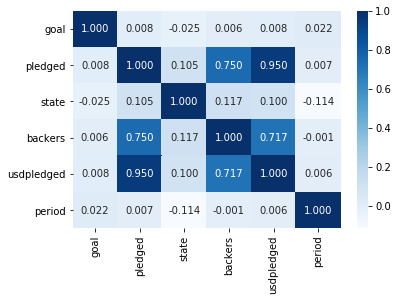

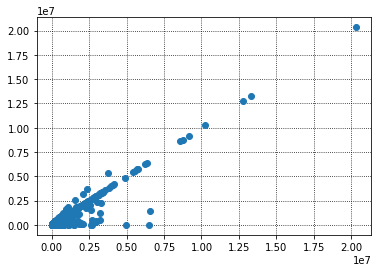

相関係数: 0.000


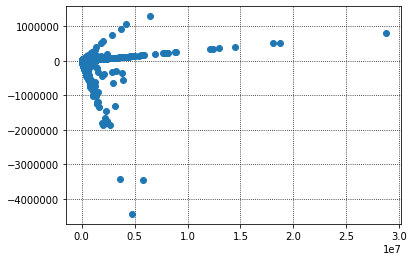

             pledged    uspledged
0           0.000000     0.000000
1         311.004083     8.744170
2           1.413655     0.039746
3       74040.176517  2081.708742
4        1703.454180    47.894206
...              ...          ...
281087     35.341373     0.993656
281088    219.116513     6.160665
281089     28.273098     0.794925
281090    282.730984     7.949246
281091    740.755179    20.827024

[281092 rows x 2 columns]


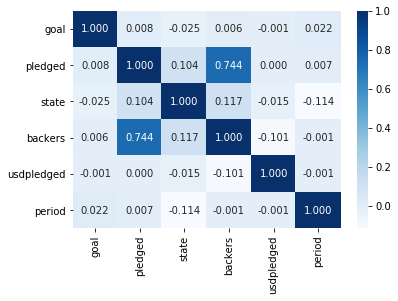

In [65]:
# 相関係数
print(df.corr())

# 相関係数の可視化
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='1.3f')
plt.show()

plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(df['pledged'], df['usdpledged'], 'o')
plt.show()

# 説明変数の相関をなくす
df_pledged = pd.DataFrame({'pledged' : df['pledged'], 'usdpledged' : df['usdpledged']})
df_pledged.reset_index(inplace=True, drop=True)
cov = np.cov(df_pledged, rowvar=0)
_, S = np.linalg.eig(cov)
pledged_decorr = np.dot(S.T, df_pledged.T).T

print('相関係数: {:.3f}'.format(np.corrcoef(pledged_decorr[:, 0], pledged_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(pledged_decorr[:, 0], pledged_decorr[:, 1], 'o')
plt.show()

# 無相関化した変数を元のデータセットに返す。
pledged_decorr = pd.DataFrame(pledged_decorr, columns=['pledged','uspledged'])
print(pledged_decorr)
df['pledged'] = pledged_decorr.loc[:,'pledged']
df['usdpledged'] = pledged_decorr.loc[:,'uspledged']

sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt='1.3f')
plt.show()

df_dummy = pd.get_dummies(df['main_category'])
df = pd.concat([df.drop(['main_category'],axis=1),df_dummy],axis=1)
df_dummy = pd.get_dummies(df['currency'])
df = pd.concat([df.drop(['currency'],axis=1),df_dummy],axis=1)



In [ ]:
df.to_csv('./data')

In [ ]:
url = 'https://raw.githubusercontent.com/ground0state/for_qiita/master/data/iris.csv'
res = requests.get(url).content
df = pd.read_csv(StringIO(res.decode('utf-8')), header=0, index_col=0)


In [ ]:
# ホールドアウト
y = df['state'].values
X = df.drop('state', axis=1).values
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# 標準化
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

# 予測
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True)
#loss：損失関数　max_iter：学習の最大回数　fit_intercept：切片を求める
clf.fit(X_train, y_train)
y_prd_train = clf.predict(X_train)
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_prd_train))) # '対数尤度 を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_train, y_prd_train))) # 正答率を表示
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_prd_train) #適合率・再現率・F1値を計算
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0])) # 適合率を表示
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0])) # 再現率を表示
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0])) #F1値を表示

### 問題3：なぜこんなに良い数値が出たのか調べてみましょう
ヒント：特徴量の重要度を可視化してみるといいですね！
特徴量の重要度：clf.coef_ (clf.coef_の0行目)
特徴量の名前：df.drop('state',axis=1).columns